# Name: Chloe Wohlgemuth
### COSC247
### Adaline

## Adaline Assignment Instructions
Submit a Jupyter notebook containing Python code that trains two different models to classify data of your choosing, and compares the performance of the two models. The models must be two of these three: Perceptron, Adaline, and Adaline with stochastic gradient descent. You should use the same data for both models, but you may scale your features differently for each model if you wish. You may compare the two models in any meaningful way that you wish, possibly including final classification accuracy, time to convergence, or robustness to changes in the random seed, weight initialization, learning rate, or number of iterations. The nature of the comparison that you will perform should be made clear at the beginning of your notebook, and the results of the comparison should be presented (numerically, graphically, or however makes the most sense) and briefly explained at the end.

As with the previous assignment, you should work with data that relates to something that interests you personally. It can be the data you used previously, or entirely new data. In any case, your data should not be the same as that used by any of your classmates, as far as you know.

You may begin with the implementations of the learning algorithms in our textbook, or with the modified versions of that code presented in class. Alternatively, you may implement your own version from scratch, in which case you may use NumPy and Pandas, but not scikit-learn.

You are encouraged to collaborate with classmates in completing this assignment, but you should acknowledge all help that you have received in a comment in your notebook file.

You can assume that your code will be run in a Python 3.8 environment in which numpy, matplotlib, and pandas have been installed.

Your should submit your notebook (`.ipynb`) file, your data file (probably a `.csv` file), and any other files that your code requires.

## Dataset Info
This is a dataset that consists of various features of stars. Some of the pertinent ones are:
* Absolute Temperature (in K)
* Relative Luminosity (L/L_o)
* Absolute Magnitude (M_v)
* Spectral Class (O,B,A,F,G,K,,M)
* Star Type *(Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants)*

Constant(s):
* L_o = 3.828 x 10^26 Watts (Avg Luminosity of Sun)

#### Source
Data from: Abundances in dwarfs, subgiants, and giants (da Silva+, 2015) (https://astronexus.com/hyg)
* Github rep link: https://github.com/astronexus/HYG-Database/blob/master/hygdata_v3.csv
- Output format specified: 



-- output format : csv
SELECT "J/A+A/580/A24/stars".Name,  "J/A+A/580/A24/stars".Class,  "J/A+A/580/A24/stars".SpType,  "J/A+A/580/A24/stars".Vbroad,  "J/A+A/580/A24/stars".Teff,  "J/A+A/580/A24/stars"."B-V",  "J/A+A/580/A24/stars".VMag,  "J/A+A/580/A24/stars".logL
FROM "J/A+A/580/A24/stars"

## Purpose
The purpose in studying this dataset is to classify stars in the celestial space based on the Hertzsprung-Russell (HR) Diagram by plotting their features on that graph. We do this by training a Perceptron model and an Adaline model to classify between Giant vs Dwarf stars based on luminosity and surface temperature data. 

We will compare the performance of the different models in classification of stars. This can be an important task because of the different properties, compositions, behaviors, etc. of different classes of stars. This has effects on their motion, reactions (chemical, nuclear, etc.), interactions with space and bodies around them, etc. Our very understanding of the universe can be based on our studies of the different spectral bodies. 

Hertzsprung-Russell Diagram:
![Image of HR Diagram](https://cdn.eso.org/images/screen/eso0728c.jpg)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st

In [8]:
# these set the pandas defaults so that it will print ALL values, even for very long lists and large dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Process Dataset

For a more definitively linearly separable dataset (for our model/algorithm to handle), we truncate the dataset to exclude subgiant entries.

In [12]:
#read in the data, skipping the first 73 rows of ancillary information
data=pd.read_csv('result.csv')
data['Teff'] = data['Teff'] / 100 #convert K to kiloK --> Perceptron better handles features of similar orders of magnitudes

#find the indices of all entries where pl_discmethod is one of these four
inds = [j for j in range(len(data)) if data['Class'][j] != "subgiant"]
# inds = [j for j in range(len(data))]

# dataframes for plotting
y = data.iloc[inds, 1].values # class 'dwarf' vs 'giant'
# y = y[y[:].argsort()] # sort based on first (only) column
y = np.where(y == 'dwarf', -1, 1)
x = data.iloc[inds,[4,7]].values # Temperature and Luminosity

print(x.shape)

(279, 2)


## Plot dataset

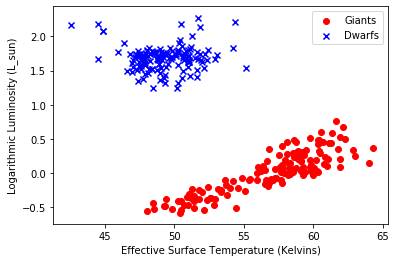

In [4]:
# plot data
plt.scatter(x=x[:139, 0], y=x[:139, 1],
            color='red', marker='o', label='Giants')
plt.scatter(x=x[139:, 0], y=x[139:, 1],
            color='blue', marker='x', label='Dwarfs')

plt.xlabel('Effective Surface Temperature (Kelvins)')
plt.ylabel('Logarithmic Luminosity (L_sun)')
plt.legend(loc='upper right')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

## Perceptron Model

In [5]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
#         self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
#             print(ppn.w_)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [6]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.2):

    # setup marker generator and color map
    markers = ('x','o','^','v','s')
    colors = ('blue','red','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Adaline Stochastic Gradient Descent 
(to predict whether a star belongs to a dwarf or a giant categorization)

In [7]:
# standardize features
X_std = np.copy(x)
X_std[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()
X_std[:, 1] = (x[:, 1] - x[:, 1].mean()) / x[:, 1].std()

In [8]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
#         print(self.w_)
#         print("xi:,xi,"target:),target,"output:",output,"error:"error)
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

## Results

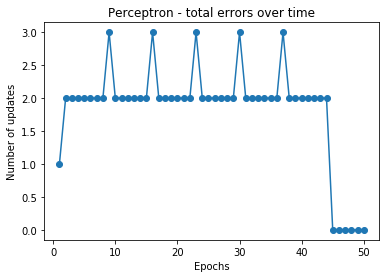

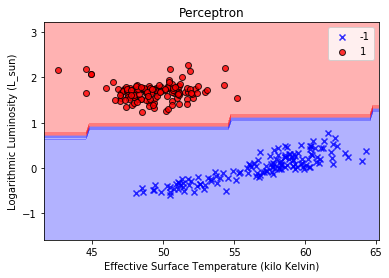

In [9]:
#Plot ppn errors
ppn = Perceptron(eta=0.01, n_iter=50)

ppn.fit(x, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.title('Perceptron - total errors over time')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.show()

# Plot decision regions
plot_decision_regions(x, y, classifier=ppn)
plt.title('Perceptron')
plt.xlabel('Effective Surface Temperature (kilo Kelvin)')
plt.ylabel('Logarithmic Luminosity (L_sun)')
plt.legend(loc='upper right')

plt.show()

# print(pp.errors_) #print the number of errors encountered in each epoch over the entire time

In [10]:
ppn.predict(np.array([1800,150])) # predict the classification/outcome for the inputted data point values

array(1)

In [11]:
ppn.predict(np.array([100000,0]))

array(-1)

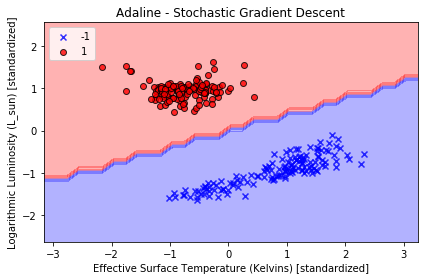

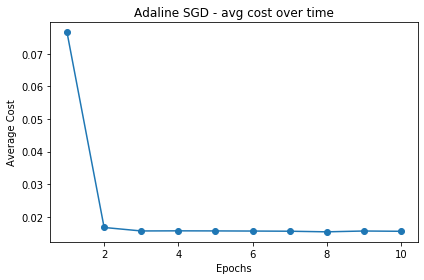

In [12]:
ada_sgd = AdalineSGD(n_iter=10, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Effective Surface Temperature (Kelvins) [standardized]')
plt.ylabel('Logarithmic Luminosity (L_sun) [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.title('Adaline SGD - avg cost over time')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

## Comparisons - Perceptron vs Adaline SGD
* **Classification Ability** --> number of examples successfully classified

Both successfully classify all the examples. --> *However,* when the **second assignment for 'inds' in cell 3 is uncommented** (when subgiants are included in the dataset) the Perceptron is not able to delineate between any of the examples with 100 passes over the training set while Adaline SGD performs the same.

* **Wallclock runtime** --> number of iterations taken

With the other (hyper) parameter(s) kept the same, learning rate = 0.01, Adaline SGD succeeded in (best) classifying the examples while taking less iterations. The Adaline SGD model took about 5 iterations and the Perceptron model took about 45 iterations to minimize the errors or cost. 

<!-- * Performance across **Learning Rates** -> performance (least errors) across different inputted learning rates
 -->

* Qualitatively / in context --> line of separation should be approximated by the Main Sequence on the HR diagram

The line of separation should have about the same shape or slope as the main sequence of stars on the HR diagram. Adaline SGD distinctly draws a line of separation that more distantly delineates the groups and more accurately represents the qualitative separation relationship. This comparison is not as quantitatively significant, but is nonetheless something that can and should be noted.